# MetaChat and downstream analysis on 3D transcriptomics from whole mouse brain

In this tutorial, we use whole mouse brain as an example to show the basic application of MetaChat to 3D transcriptomics [[Ortiz et.al., 2020](https://www.science.org/doi/10.1126/sciadv.abb3446)].

In [ ]:
# Importing packages
import os
import metachat as mc
import numpy as np
import pandas as pd
import scanpy as sc
import trimesh
import napari

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Setting your work dictionary
os.chdir("/home/project/metachat_packages/")

## Import dataset

Here, we directly provide the combined transcriptomics and metabolomics dataset that has been preprocessed for MetaChat.
For detailed instructions on how to infer metabolomic profiles from transcriptomic data using scFEA, please refer to the [tutorial](https://metachat.readthedocs.io/en/latest/tutorials/basic/estimate_metabolomics/scFEA.html).

In [4]:
adata = sc.read("datasets/mouse_brain_3D/adata_combined.h5ad")

The cluster information is previously saved in the `adata.obs['ABA_parents']`. We can use mc.pl.plot_3d_feature

In [ ]:
adata.uns['ABA_parent_colors'] = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#17becf", "#bcbd22", "#e377c2", "#8c564b", "#7f7f7f", "#393b79", "#e6550d", "#637939", "#a55194", "#8c6d31"]
mc.pl.plot_3d_feature(adata, 
                feature = 'ABA_parent',
                figsize = (5,10),
                point_size = 2,
                show_axes = False)

<img src="../../_static/image/3D/plot_1.png" alt="plot_1" width="1000"/>

## MCC Inference

### Import MetaChatDB

Load the curated MetaChat database containing metabolite–sensor interaction pairs for mouse (or human).

In [6]:
df_metasen = mc.pp.MetaChatDB(species='mouse') # If human, please input species='human'.

### Identify long-range channels (LRCs)

In this example, we aim to identify cerebrospinal fluid (CSF) as potential LRC pathways.
To achieve this, we use a gene-marker–based approach to locate candidate points, leveraging the expression of known vascular markers to guide the identification of regions likely involved in long-range metabolite transport.

In [7]:
LRC_name = "CSF"
LRC_marker_gene = "Gfap"

In [ ]:
pl = mc.pl.plot_3d_feature(adata, 
                feature = 'Gfap',
                figsize = (5,10),
                point_size = 2,
                show_axes = False)

<img src="../../_static/image/3D/plot_2.png" alt="plot_2" width="1000"/>

In [9]:
adata.obs['CSF_marker'] = adata[:, LRC_marker_gene].X.toarray().ravel()

In [10]:
mc.pp.LRC_unfiltered(adata = adata,
                     LRC_name = LRC_name,
                     LRC_source = "marker",
                     obs_name = 'CSF_marker',
                     quantile = 90)

Cells above the 90% have been selected as candidates and stored in 'adata.obs['LRC_CSF_marker_unfiltered']'.


In [ ]:
adata.uns['LRC_CSF_marker_unfiltered_colors'] = ["#d3d3d3", "#ff7f0e"]
mc.pl.plot_3d_feature(adata, 
                      feature = 'LRC_CSF_marker_unfiltered',
                      figsize = (5,10),
                      point_size = 2,
                      opacity = [0.2,0.8],
                      show_axes = False)

<img src="../../_static/image/3D/plot_3.png" alt="plot_3" width="1000"/>

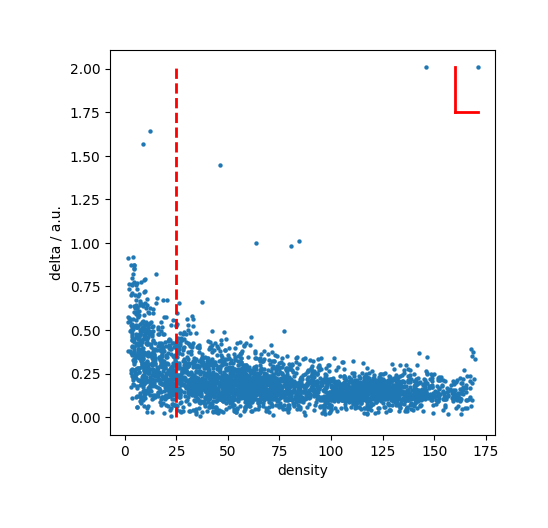

In [12]:
LRC_cluster_CSF = mc.pp.LRC_cluster(adata = adata,
                                    LRC_name = LRC_name,
                                    LRC_source = "marker",
                                    spatial_index = "spatial_3d",
                                    density_cutoff = 160,
                                    delta_cutoff = 1.75,
                                    outlier_cutoff = 25)

Then, the `mc.pp.LRC_filtered()` function was executed to remove outlier points from the clustered CSF LRC candidates, and the filtered LRCs were stored in adata.obs['LRC_CSF_marker_filtered'].

In [13]:
mc.pp.LRC_filtered(adata = adata,
                   LRC_name = LRC_name,
                   LRC_cluster = LRC_cluster_CSF,
                   LRC_source = "marker")

Candidate points for CSF LRC are clustered and outliers are removed. LRC points are stored in 'adata.obs['LRC_CSF_marker_filtered']'.


/home/project/metachat_packages/MetaChat-main/metachat_new/preprocessing/_identifyLRC.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
adata

AnnData object with n_obs × n_vars = 33022 × 16211
    obs: 'section_index', 'stereo_ML', 'stereo_DV', 'stereo_AP', 'HE_X', 'HE_Y', 'ABA_acronym', 'ABA_name', 'ABA_parent', 'nuclei_segmented', 'spot_radius', 'passed_QC', 'cluster_id', 'cluster_name', 'animal', 'ABA_id', 'ABA_name_level2', 'ABA_name_level1', 'ABA_color_level2', 'ABA_color_level1', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'CSF_marker', 'LRC_CSF_marker_unfiltered', 'LRC_CSF_marker_filtered'
    uns: 'log1p', 'ABA_parent_colors', 'LRC_CSF_marker_unfiltered_colors'
    obsm: 'spatial', 'spatial_3d'

In [ ]:
# Set color for LRCs
adata.uns['LRC_CSF_marker_filtered_colors'] = ["#d3d3d3", "#ff7f0e"]
mc.pl.plot_3d_feature(adata, 
                      feature = 'LRC_CSF_marker_filtered',
                      figsize = (5,10),
                      point_size = 2,
                      opacity = [0.2,0.8],
                      show_axes = False)

<img src="../../_static/image/3D/plot_4.png" alt="plot_4" width="1000"/>

In [ ]:
fig = mc.pl.plot_3d_LRC_with_two_slices(
    adata,
    mask_key = "LRC_CSF_marker_filtered",
    z_levels = [-1.0, -3.88],
    slab_ratio = 0.04,
    bg_color = "#7f7f7f",
    flatten_z = False
)
fig.show()

<img src="../../_static/image/3D/plot_8.png" alt="plot_8" width="2000"/>

### Compute cost distance

Determined dis_thr

In [ ]:
from scipy.spatial import distance_matrix
adata.obsp['spatial_distance'] = distance_matrix(adata.obsm["spatial_3d"], adata.obsm["spatial_3d"])
spot_index = 11150
dis_thr = 0.8
adata_vis = adata.copy()
dis_mat = adata_vis.obsp['spatial_distance']
adata_vis.obs['inside'] = dis_mat[spot_index,:] < dis_thr
mc.pl.plot_3d_feature(adata_vis, 
                      feature = 'inside',
                      figsize = (5,10),
                      point_size = 2,
                      opacity = [0.2,0.8],
                      show_axes = False)

<img src="../../_static/image/3D/plot_5.png" alt="plot_5" width="1000"/>

The function mc.pp.compute_costDistance() calculates the spatial cost distance matrix between all spots, integrating both Euclidean proximity and long-range channel (LRC) effects. Specifically, it adjusts the pairwise distances according to the defined `LRC_type` and their corresponding `LRC_strength`, allowing metabolite diffusion or communication along designated LRC paths to be modeled more realistically. 

The parameters `LRC_type` and `LRC_source` should correspond to the names used in adata.obs['LRC_<LRC_type>_<LRC_source>_filtered'].
A higher value of `LRC_strength` indicates a stronger influence of long-range communication, effectively expanding the propagation range through LRCs. The parameter `dis_thr` should match the distance threshold defined in the previous step.
We support and recommend setting `use_parallel = True` and increasing `n_jobs` within the limits of your system performance, as this can significantly accelerate the computation of the cost distance matrix. The resulting distance matrix is stored in adata.obsp (e.g., adata.obsp['spatial_distance_LRC_CSF']) and can be used in downstream analyses of metabolic cell communication.

In [22]:
mc.pp.compute_costDistance(
    adata = adata,
    LRC_type = ['CSF'],
    LRC_strength = [3],
    LRC_source = "marker",
    dis_thr = 0.8,
    spatial_3d = True,
    k_neighb = 10,
    use_parallel = True,
    n_jobs = 64
)

Computing baseline spatial distance without LRC.
  Barrier condition is not considered
Computing spatial distance with LRCs.
  Processing LRC type: CSF
    Constructing graph for each LRC subcluster.
    Computing shortest path between two points in CSF.
      For the cluster 1 in CSF.


100%|██████████| 2683/2683 [04:29<00:00,  9.94it/s]


    Incorporating LRC strength of 'CSF' into cost distance matrix (strength = 3).
adata.obsp['spatial_distance_LRC_CSF'] has been saved.
Finished!


In [23]:
adata

AnnData object with n_obs × n_vars = 33022 × 16211
    obs: 'section_index', 'stereo_ML', 'stereo_DV', 'stereo_AP', 'HE_X', 'HE_Y', 'ABA_acronym', 'ABA_name', 'ABA_parent', 'nuclei_segmented', 'spot_radius', 'passed_QC', 'cluster_id', 'cluster_name', 'animal', 'ABA_id', 'ABA_name_level2', 'ABA_name_level1', 'ABA_color_level2', 'ABA_color_level1', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'CSF_marker', 'LRC_CSF_marker_unfiltered', 'LRC_CSF_marker_filtered', 'LRC_CSF_closepoint_cluster1'
    uns: 'log1p', 'ABA_parent_colors', 'LRC_CSF_marker_unfiltered_colors', 'LRC_CSF_marker_filtered_colors'
    obsm: 'spatial', 'spatial_3d'
    obsp: 'spatial_distance', 'spatial_distance_LRC_base', 'LRC_shortest_CSF_dist0.8_cluster1', 'spatial_distance_LRC_CSF'

In [24]:
mc.tl.metabolic_communication(adata = adata,
                              database_name = 'MetaChatDB',
                              df_metasen = df_metasen,
                              LRC_type = ["CSF"],
                              dis_thr = 0.8)

There are 217 pairs were found from the spatial data.


In [ ]:
adata.write("datasets/mouse_brain_3D/metachat_result.h5ad")

## Downstream analysis on glutamate and glutamine

First, we can visualize the 3D spatial distribution of glutamate (HMDB0000148) and glutamine (HMDB0000641).

In [ ]:
mc.pl.plot_3d_feature(adata, 
                      feature = 'HMDB0000148',
                      figsize = (5,10),
                      point_size = 2,
                      show_axes = False)

<img src="../../_static/image/3D/plot_6.png" alt="plot_6" width="1000"/>

In [ ]:
mc.pl.plot_3d_feature(adata, 
                      feature = 'HMDB0000641',
                      figsize = (5,10),
                      point_size = 2,
                      show_axes = False)

<img src="../../_static/image/3D/plot_7.png" alt="plot_7" width="1000"/>

### Compute group-level MCC

First, we need to summarize MCC of these two metabolites . 

In [27]:
sum_metabolites = ['HMDB0000148','HMDB0000641']

In [28]:
mc.tl.summary_communication(adata = adata,
                            database_name = 'MetaChatDB',
                            sum_metabolites = sum_metabolites)

In [29]:
mc.tl.communication_group(adata = adata,
                          database_name = 'MetaChatDB',
                          group_name = "ABA_parent",
                          sum_metabolites = sum_metabolites,
                          n_permutations = 100,
                          use_parallel = True,
                          n_jobs = 16)

  Computing group-level MCC: 100%|██████████| 3/3 [02:35<00:00, 51.82s/it]


Text(0.5, 1.0, 'With Self Communication')

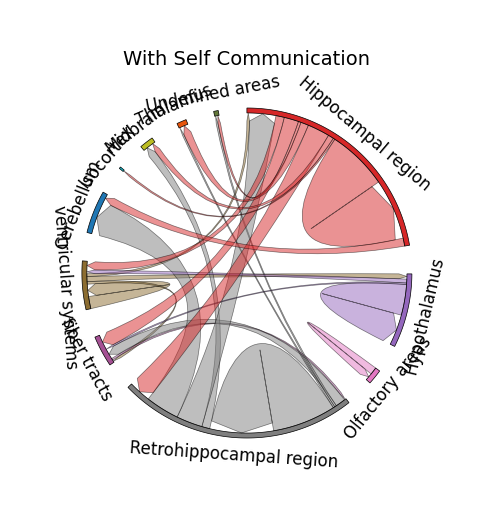

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5,4.5), subplot_kw={'projection': 'polar'})
mc.pl.plot_group_communication_chord(adata = adata,
                                     database_name = 'MetaChatDB',
                                     group_name = "ABA_parent",
                                     metabolite_name = 'HMDB0000148',
                                     permutation_spatial = False,
                                     p_value_cutoff = 0.05,
                                     space = 10,
                                     self_communication_off = False,
                                     ax = ax)
ax.set_title('With Self Communication', fontsize=14)

Text(0.5, 1.0, 'With Self Communication')

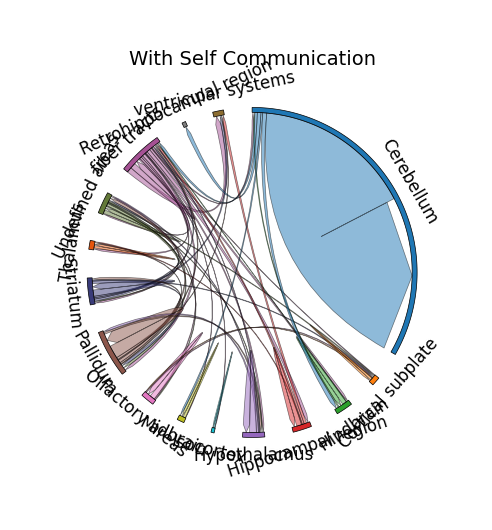

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5,4.5), subplot_kw={'projection': 'polar'})
mc.pl.plot_group_communication_chord(adata = adata,
                                     database_name = 'MetaChatDB',
                                     group_name = "ABA_parent",
                                     metabolite_name = 'HMDB0000641',
                                     permutation_spatial = False,
                                     p_value_cutoff = 0.05,
                                     space = 10,
                                     self_communication_off = False,
                                     ax = ax)
ax.set_title('With Self Communication', fontsize=14)

### Compute MCC flow

In [36]:
mc.tl.communication_flow(adata = adata,
                         database_name = 'MetaChatDB',
                         sum_metabolites = sum_metabolites,
                         spatial_key = 'spatial_3d',
                         k = 5)

Then we can visualize 3D MCC flow through Napari. First, we load the 3D brain surface mesh from an .obj file using trimesh. This mesh provides the anatomical geometry that will be used as a spatial reference for visualizing. trimesh can be installed by `pip install trimesh`.

In [40]:
brain_mesh = trimesh.load("datasets/mouse_brain_3D/brain-outline.obj")
vertices = np.array(brain_mesh.vertices)
faces = np.array(brain_mesh.faces)

For ease of comparison, we selected half of the tissue region to visualize both the metabolite distribution and the corresponding 3D flow vector field. This allows clearer visualization of spatial patterns and directional features without occlusion from the full-volume data.

In [ ]:
# extract metabolite distribution
metabolite = "HMDB0000148"
expression = adata[:, metabolite].X.toarray().flatten()
# extract spatial coordinates
coords = adata.obsm['spatial_3d']

In [ ]:
# launch napari and import brain model
viewer = napari.Viewer(ndisplay=3)
viewer.theme = 'light'
viewer.add_surface(
    (vertices, faces),
    name="Brain Model",
    blending = 'translucent_no_depth',
    opacity=0.1,
    colormap='gray',
    shading='flat'
)

In [ ]:
# import points with cell type annotation
from matplotlib.colors import to_rgba
if not pd.api.types.is_categorical_dtype(adata.obs['ABA_parent']):
    adata.obs['ABA_parent'] = adata.obs['ABA_parent'].astype('category')
cats = list(adata.obs['ABA_parent'].cat.categories)

type_colors_array = np.array(adata.uns['ABA_parent_colors']).astype(str)
if len(type_colors_array) < len(cats):
    raise ValueError("Number of colors < number of cell types; please provide enough colors.")
color_map = {ct: type_colors_array[i] for i, ct in enumerate(cats)}

cell_types = adata.obs['ABA_parent'].astype(str).values
hex_list = [color_map[ct] for ct in cell_types]
rgba = np.array([to_rgba(h) for h in hex_list], dtype=float)

layer_cells = viewer.add_points(
    coords,
    name="Cells_byType",
    size=0.1,
    blending='translucent_no_depth',
    face_color=rgba,         # 直接传 RGBA 数组
    opacity=0.6,
    shading='spherical',
    properties={'ABA_parent': cell_types}
)
layer_cells.rendering = 'iso'

In this step, we visualize all cells in the 3D tissue volume while highlighting those with high expression levels of a selected gene. We first compute the 95th percentile of the expression values as a threshold, and then mark cells above this threshold as high-expression regions. All cells are rendered as semi-transparent white points for context, whereas high-expression cells are displayed in red to emphasize their spatial localization within the tissue.

In [ ]:
threshold = np.percentile(expression, 95)
high_idx = expression > threshold

# ---------------------------
features_all = pd.DataFrame({'expression': expression})
layer_all = viewer.add_points(
    coords,
    name="Cells_All",
    blending = 'translucent_no_depth',
    size=0.1,
    features=features_all,
    face_color='white',
    opacity=0.05,
    shading='spherical'
)
layer_all.rendering = 'iso'

# ---------------------------
coords_high = coords[high_idx]

features_high = pd.DataFrame({'expression': expression[high_idx]})
layer_high = viewer.add_points(
    coords_high,
    name="Cells_High",
    size=0.1,
    features=features_high,
    face_color='expression',
    face_colormap='Reds',
    opacity=1.0,
    shading='spherical'
)
layer_high.rendering = 'iso'

In [ ]:
start = adata.obsm["spatial_3d"]
direction = adata.obsm['MetaChat-vf-MetaChatDB-sender-HMDB0000148']

Prepare and preprocess 3D vector field. We summarize the raw 3D vector field onto a regular spatial grid, which facilitates quantifying and visualizing local flow directions and magnitudes in a structured manner.

In [ ]:
start_flipped = start.copy()
direction_flipped = direction.copy()
start_flipped[:, 0] *= -1
direction_flipped[:, 0] *= -1
X = start_flipped.copy()
V = direction_flipped.copy()
V_cell = V.copy()

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm
grid_density = 1
grid_knn = None
grid_scale = 0.8
grid_thresh = 1.0
xl, xr = np.min(X[:,0]), np.max(X[:,0])
epsilon = 0.02*(xr-xl); xl -= epsilon; xr += epsilon
yl, yr = np.min(X[:,1]), np.max(X[:,1])
epsilon = 0.02*(yr-yl); yl -= epsilon; yr += epsilon
zl, zr = np.min(X[:,2]), np.max(X[:,2])
epsilon = 0.02*(zr-zl); zl -= epsilon; zr += epsilon

ngrid_x = int(20 * grid_density)
gridsize = (xr-xl) / float(ngrid_x)
ngrid_y = int((yr-yl)/gridsize)
ngrid_z = int((zr-zl)/gridsize)
meshgrid = np.meshgrid(np.linspace(xl,xr,ngrid_x), np.linspace(yl,yr,ngrid_y), np.linspace(zl,zr,ngrid_z))
grid_pts = np.concatenate((meshgrid[0].reshape(-1,1), meshgrid[1].reshape(-1,1), meshgrid[2].reshape(-1,1)), axis=1)

if grid_knn is None:
    grid_knn = int( X.shape[0] / 50)
nn_mdl = NearestNeighbors()
nn_mdl.fit(X)
dis, nbs = nn_mdl.kneighbors(grid_pts, n_neighbors=grid_knn)
w = norm.pdf(x=dis, scale=gridsize * grid_scale)
w_sum = w.sum(axis=1)

V_grid = (V[nbs] * w[:,:,None]).sum(axis=1)
V_grid /= np.maximum(1, w_sum)[:,None]

grid_thresh *= np.percentile(w_sum, 99) / 100
grid_pts, V_grid = grid_pts[w_sum > grid_thresh], V_grid[w_sum > grid_thresh]

magnitude = np.linalg.norm(V_grid, axis=1)
percentile_thresh = 70
mag_thresh = np.percentile(magnitude, percentile_thresh)
valid_mask = magnitude >= mag_thresh
grid_pts_filtered = grid_pts[valid_mask]
V_grid_filtered = V_grid[valid_mask]
magnitude_filtered = magnitude[valid_mask]

In [ ]:
vectors_grid = np.stack([grid_pts_filtered, 100*V_grid_filtered], axis=1)
features = pd.DataFrame({'magnitude': magnitude_filtered})

In [ ]:
vect = viewer.add_vectors(vectors_grid, features = features, edge_width=0.03, length=1, edge_color = 'magnitude', edge_colormap='plasma', vector_style = 'arrow')

The final result is shown below.

3D MCC flow of glutamate. 

<video width="720" height="405" controls>
  <source src="../../_static/video/MCC_flow_HMDB0000148.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

3D MCC flow of glutamine. 

<video width="720" height="405" controls>
  <source src="../../_static/video/MCC_flow_HMDB0000641.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>